## Stat 135 Lab 1

### Ishaan Srivastava

In this report, we explore the concentration of Radon levels in sampled households in Minnesota, USA. Radon is a radioactive gas and known carcinogen, causing lung cancer (especially in miners). While Radon is fairly harmless in outside environments since it mixes with the surrounding atmosphere, it can be quite dangerous in indoor settings if allowed to accumulate as it can stick to dust particles and cigarette smoke and irradiate the respiratory track when inhaled. Hence, indoor Radon levels of sampled houses were measured with the intention of drawing meaningful conclusions about the proportion of houses in Minnesota with indoor concentration of Radon exceeding 4 picoCuries per liter (or 4 pCi/l) to consequently assess the safety and health of the population with regard to Radon. Throughout this report, "excess Radon" will refer to concentrations of Radon exceeding the EPA guideline of 4 piC/l

Note that the textbook says that "The original survey design was to use sampling rates proportional to county populations" and as such, the relevant calculations are performed assuming proportional stratified sampling was the sampling method used, where a simple random sample is taken of each stratum (county), and each stratum is appropriately weighted by the number of people in the stratum (county) relative to the total population (number of households in the state).

We begin by importing the relevant libraries and reading in the relevant data. Note that two counties (26 and 63) have no data ie. the number of sampled households is 0, hence these counties are excluded in our calculations for now. More information on this is provided later.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
radon_boi = pd.read_csv("radon.data", sep = "\s+")
county_boi = pd.read_csv("county.sizes", sep = "\s+")
county_boi = county_boi[county_boi["sample"] > 0]

Relevant snippets of the tables are provided to help clarify the nature of the data we're working with. More detailed descriptions of the data are available at https://www.stat.berkeley.edu/users/statlabs/labs.html#radon

In [3]:
county_boi.head(1)

,county,sample,population
0,1,4,54


In [4]:
radon_boi.head(1)

,county,radon
0,1,1.0


In [5]:
merged_boi = radon_boi.merge(county_boi, on = "county")
merged_boi.head(1)

,county,radon,sample,population
0,1,1.0,4,54


We use the indicator $I_{j,i}$ to denote whether the the $i$-th sampled house in the $j$-th stratum has excess Radon, with the value of 1 if yes and 0 if not. In the following cell, the proportion of sampled houses having excess indoor Radon is calculated for each county and provided in the column "Stratum Proportion". The sample proportion for each stratum is simply the average of the indicators in the sample for that stratum. Formulaically, this is represented as $\tilde{x}_j = \frac{1}{n_j} \sum^{n_j}_{i = 1}I_{j,i}$ where $n_j$ is the number of houses sampled in the $j$-th stratum. Once again, a table snippet is provided for convenience.

In [6]:
sample_prop_boi = merged_boi.groupby("county").agg(lambda x: np.mean(x["radon"] > 4))["radon"]
county_boi["Stratum Proportion"] = sample_prop_boi.values
county_boi.head(1)

,county,sample,population,Stratum Proportion
0,1,4,54,0.0


Armed with this data, we are now able to estimate the proportion of houses in the state with excess indoor Radon. In accordance with the principles of proportional stratified random sampling, the estimated proportion of houses having excess Radon in Minnesota $\tilde{x}$ is calculated as $\tilde{x} = \sum^j_{i=1} \frac{N_i}{N} \tilde{x_i}$, where $N_i$ is the number of households in the $i$-th stratum, $N$ is total number of households in Minnesota, $\tilde{x_i}$ is the estimated proportion in the $i$-th proportion, and there are $j$ strata (counties) overall. Note that the population size is reported in 100s, and calculations are handled acoordingly.

In [7]:
total_N = np.sum(county_boi["population"])
overall_sample_prop = np.sum(county_boi["population"]/total_N*county_boi["Stratum Proportion"])
np.round(overall_sample_prop, 4)

0.4724

We see that the estimated proportion is approximately **0.4724 or 47.24%**.

Estimated standard error for proportion for the $j$-th stratum is $\tilde{x_j}$ is SE$(\tilde{x_j}) = \sqrt{\frac{\tilde{x_j}(1-\tilde{x_j})(N_j - n_j)}{(n_j - 1)N}}$. We obtain overall estimated standard error SE$(\tilde{x})$ in the following cell by weighting the estimated standard error for each stratum the same we did for estimating population proportion. Note that for strata having only 1 sampled house, the sample proportion must be 0 or 1, so $\tilde{x_j} * (1 - \tilde{x_j})$ = 0 and hence estimated standard error is also 0. This special case is handled using the `inter` variable (short for intermediate).

In [8]:
stratum_prop = county_boi["Stratum Proportion"]
inter = np.sqrt(stratum_prop*(1-stratum_prop))*np.sqrt((county_boi["population"] * 
                          100 - county_boi["sample"])/(county_boi["population"] * 100))
samp_boi = county_boi["sample"]
inter[inter != 0] = inter[inter != 0]/np.sqrt(samp_boi[samp_boi > 1] - 1)
np.round(np.sum(county_boi["population"]/total_N*inter), 4)

0.1017

Hence the estimated standard error to my estimate is approximately **0.1017 or 10.17%**.

In the case of counties having few sampled houses, the possible values of estimated proportion of houses having excess Radon are also few. In the case where 4 houses are sampled, the only possible estimated proportions are 0, 0.25, 0.50, 0.75, 1. To help stabilise this, we perform proportional stratified random sampling using that county and its neighbors as the strata, as opposed to all the counties in the state. This is done for county 81 in the following cells, which has neighbours 7, 40, 66, 74, 22, 24. Note that county 81 has 4 sampled houses and an estimated proportion of 0.25 households with excess Radon.

In [9]:
county_boi[county_boi["county"] == 81]

,county,sample,population,Stratum Proportion
80,81,4,69,0.25


In [10]:
valid_counties = np.array([7,22,24,40,66,74,81])
modified_county = county_boi[county_boi["county"].isin(valid_counties)]
np.round(np.sum(modified_county["population"]/(sum(modified_county["population"])) * modified_county["Stratum Proportion"]), 4)

0.6548

We notice a substantial increase in our estimated proportion from **0.2500 to 0.6548** after performing our aforementioned procedure.

Let us now geographically inspect the data. Here, the proportion of sampled houses in a given county having excess Radon levels is used as an estimate for the proportion of households in that county having excess Radon. The counties are divided into 5 categories based on the estimated proportion of households having excess Radon in each county. In intervals of 0.25, the counties are classified as "Low", "Moderate", "High", and "Very High" for estimated proportion of households with excess Radon. Counties 26 and 63 are categorised as "No Data". We use the geopandas package to colour the map accordingly, and axis values are excluded for clarity. Relevant geodata was obtained from https://gisdata.mn.gov/dataset/bdry-counties-in-minnesota

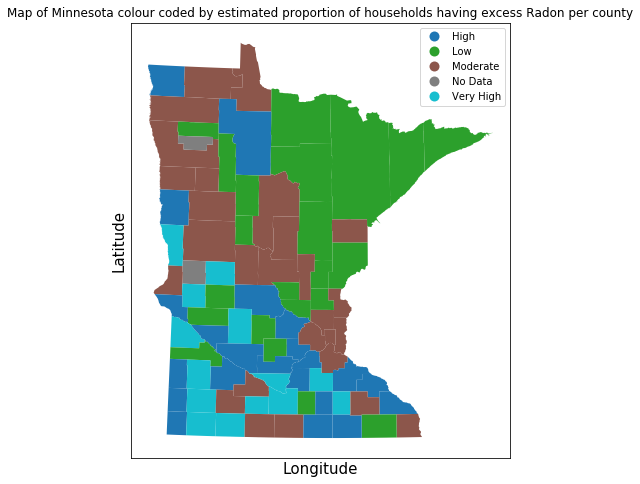

In [11]:
geodata = gpd.read_file("bdry_counties_in_minnesota.gpkg")
merged_geodata = geodata.merge(county_boi, left_on = "COUN", right_on = "county", how = "outer")
merged_geodata["Category"] = "No Data"
merged_geodata.loc[merged_geodata["Stratum Proportion"] <= 0.25, "Category"] = "Low"
merged_geodata.loc[(merged_geodata["Stratum Proportion"] <= 0.50) & (merged_geodata["Stratum Proportion"] > 0.25), "Category"] = "Moderate"
merged_geodata.loc[(merged_geodata["Stratum Proportion"] <= 0.75) & (merged_geodata["Stratum Proportion"] > 0.50), "Category"] = "High"
merged_geodata.loc[merged_geodata["Stratum Proportion"] > 0.75, "Category"] = "Very High"
merged_geodata.plot("Category", legend = True, figsize = (8,8));
plt.xticks([]);
plt.yticks([]);
plt.title("Map of Minnesota colour coded by estimated proportion of households having excess Radon per county");
plt.xlabel("Longitude", fontsize = 15);
plt.ylabel("Latitude", fontsize = 15);

Broadly speaking, the northeastern part of the state seems to have quite low estimated proportions of households with excess Radon, while the northwestern has a higher but still relatively moderate estimated proportion of them. The southern half of the state has far more counties where the estimated proportion is in the "High" or even "Very High" category. These are all broad statements, since exceptions to the general trend exist in each quadrant. The notable limitations are as follows. This map does not account for differing county populations so we are unable to conclude how population is relevant here. Additionally we examine Radon concentration from a binary perspective of whether the indoor concentration of Radon exceeds 4 piC/l or not, but there is no analysis of how much this level is exceeded or avoided. Note that no conclusions are made about counties 26 and 63 since we have no data for them, which is another limitation. In terms of sampling, the sampling frame ie. pool of households that was sampled from "were all those with permanent foundations, at least one floor at or below the ground level, owner occupied, and with a listed phone number." This would limit our conclusions because it excludes economically weaker people who may have low quality housing and/or don't own the house they're living in, among others. This could disproportionately exclude miners and their households which we would expect to have higher levels of Radon due to exposure in mines, falsely deflating the estimated proportions of households with excess Radon. Additionally there were those eligible for the survey who declined to participate, resulting in non-response bias and further limiting the validity of the conclusions.  